# Koopman control

Based on the paper "Koopman Invariant Subspaces and Finite Linear Representations of Nonlinear Dynamical Systems for Control".

This notebook:

#### Part I
* simulates forward the trajectories
* solve the lqr control problem
* compare the controled and uncontrolled trajectories

#### Part II
* express the problem in the "Koopman space" (TODO)
* solve the control problem in the "Koopman space" (TODO)
* compare the controled and Koopman-controlled trajectories (TODO)

## Dependencies

Notebook using Python 3:

In [234]:
!python3 --version

Python 3.5.2


The following packages are needed:

In [236]:
import os
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
%matplotlib inline
#import control
from control.matlab import *  # MATLAB-like functions 
#to solve ODE
from scipy import integrate

## Description of the problem

### Parameter values

In [89]:
mu = -0.05
llambda = -1.0

In [90]:
A = np.array([[mu, 0], [0, llambda]])
B = np.array([[0], [1]])

#### Starting values:

In [91]:
x0 = np.array([[-5], [5]])

#### Time span

In [92]:
t0, t1 = 0, 100 # start and end
t = np.arange(t0, t1, 0.01)

## Simulating forward the ODE

In [237]:
# Function that defines the dynamic system:
def vdp0(t, y):
    x = A.dot(y) + np.array([0, -llambda*(y[0]**2)])
    return x 

In [238]:
#Set of starting values:
y0A = np.array([1.5, -1])
y0B = np.array([-1.5, -1])
y0C = np.array([2, 2])
y0D = np.array([-5, 5])

# To store the different trajectories
list_y = []



# Loop over the different starting values and calculate trajectories:
for y0 in [y0A, y0B, y0C,y0D]:
    # initialize an array to store the solution
    y = np.zeros((len(t), len(y0)))   # array for solution
    r0 = integrate.ode(vdp0).set_integrator("dopri5")  # choice of method
    r0.set_initial_value(y0, t0)   # initial values
    for i in range(1, t.size):
       y[i, :] = r0.integrate(t[i]) # get one more value, add it to the array
       if not r0.successful():
           raise RuntimeError("Could not integrate")
    # append the list of solution
    list_y.append(y)

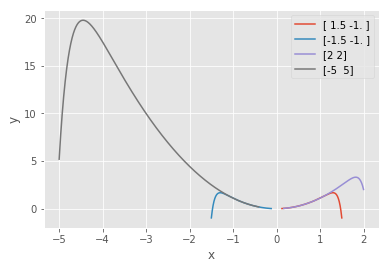

In [239]:
# Plot the different paths:
for index,y0 in enumerate([y0A, y0B, y0C, y0D]):
    plt.plot(list_y[index][1:-1, 0], list_y[index][1:-1, 1], label = str(y0))
    plt.xlabel("x")
    plt.ylabel("y")
plt.legend()
plt.show()

#### Plotting the costs

In [149]:
# Store the cost associated with each starting value:
list_cost = []
for y in list_y:
    JLQR = np.cumsum( np.square(y[:, 0]) + np.square(y[:, 1]) + np.square(np.matmul(C, y.T)) ).T
    # append the list of solution
    list_cost.append(JLQR)

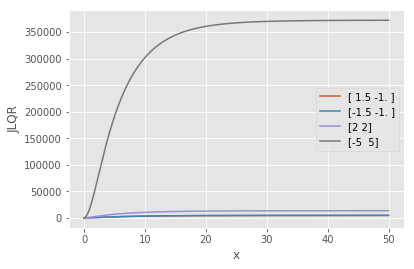

In [150]:
# Plot the cost associated with each starting value:
for JLQR, y0 in zip(list_cost,[y0A, y0B, y0C, y0D]):
    plt.plot(t, JLQR, label = str(y0))
    plt.xlabel("t")
    plt.ylabel("JLQR")
plt.legend()
plt.show()

### Solving the control problem

#### Adapting the parameters:

In [220]:
# Unstable if not controlled
#mu = -0.1
#llambda = 1.0

# Stable if not controlled
mu = -0.05
llambda = -1.0

In [221]:
A = np.array([[mu, 0], [0, llambda]])
B = np.array([[0], [1]])
R = np.array([1])
Q = np.eye(2)

In [222]:
# System matrices
(C, X, E) = lqr(A, B, Q, R)
print("Feedback matrix: {}".format(C))

Feedback matrix: [[0.         0.41421356]]


### Integrate the ODE

In [223]:
def vdp1(t, y):
    # Ay - B*X*y + Cy
    x = A.dot(y)  - np.matmul(B,C).dot(y)
    return x + np.array([0, -llambda*(y[0]**2)])

t0, t1 = 0, 50                # start and end
t = np.arange(t0,t1, 0.01)
y0 = [-5, 5]                   # initial value
y = np.zeros((len(t), len(y0)))   # array for solution
y[0, :] = y0

In [224]:
r = integrate.ode(vdp1).set_integrator("dopri5")  # choice of method
r.set_initial_value(y0, t0)   # initial values

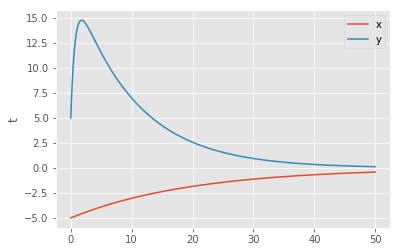

In [225]:
for i in range(1, t.size):
   y[i, :] = r.integrate(t[i]) # get one more value, add it to the array
   if not r.successful():
       raise RuntimeError("Could not integrate")
plt.plot(t, y[:,0], label = "x")
plt.plot(t, y[:,1], label = "y")
plt.ylabel("t")
plt.legend()
plt.show()

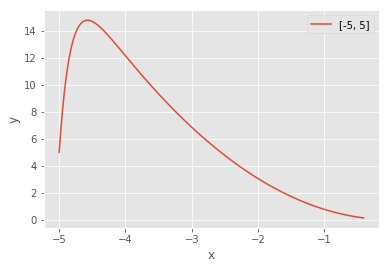

In [226]:
plt.plot(y[:, 0], y[:, 1], label = y0)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### Cumulative sum of cost

In [227]:
JLQR = np.cumsum( np.square(y[:, 0]) + np.square(y[:, 1]) + np.square(np.matmul(C, y.T)) ).T

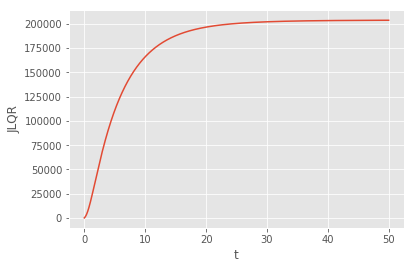

In [228]:
plt.plot(t, JLQR, label = "uncontrolled")
plt.xlabel("t")
plt.ylabel("JLQR")
plt.show()

### Controlled versus uncontrolled

Trajectories:

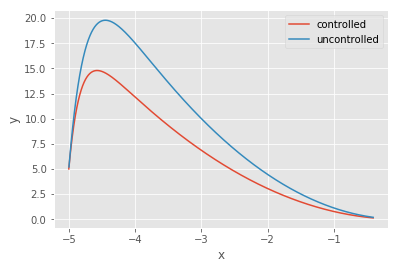

In [229]:
plt.plot(y[:, 0], y[:, 1], label = "controlled")
plt.plot(list_y[index][1:-1, 0], list_y[index][1:-1, 1], label = "uncontrolled")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Total cost:

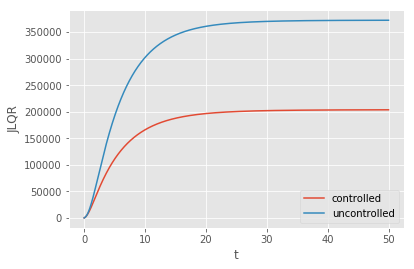

In [230]:
plt.plot(t, JLQR, label = "controlled")
plt.plot(t, list_cost[3], label = "uncontrolled")
plt.xlabel("t")
plt.ylabel("JLQR")
plt.legend()
plt.show()

## Manually

In [18]:
import numpy as np
#from control import lqr

In [19]:
from __future__ import division, print_function
 
import numpy as np
import scipy.linalg
 
def lqr(A,B,Q,R):
    #Solve the continuous time lqr controller.
    # 
    #dx/dt = A x + B u
    #
    #cost = integral x.T*Q*x + u.T*R*u
    #
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals
 
def dlqr(A,B,Q,R):
    #Solve the discrete time lqr controller.
    #
    #x[k+1] = A x[k] + B u[k]
    #
    #cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R)) 
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
 
    return K, X, eigVals

In [20]:
mu = -0.1
llambda = 1.0
σ = 1.0

In [21]:
A = np.array([[mu, 0], [0, llambda]])
B = np.array([[0], [1]])
#B = np.array([[1], [0]])

In [22]:
B

array([[0],
       [1]])

In [23]:
R = np.array([1])
Q = np.eye(2)

In [24]:
# System matrices
dlqr(A, B, Q, R)

(matrix([[-3.66380674e-19,  6.18033989e-01]]),
 matrix([[1.01010101e+00, 9.59197057e-18],
         [9.59197057e-18, 1.61803399e+00]]),
 array([ 0.38196601+0.j, -0.1       +0.j]))